# Data Mining for Security Applications: final project

This final hands on project will count for 50% of your final grade (exam is the other 50%)

## Organization
* you can start the project as of now
* the project has to be handed in no later than March 1st - NO EXTENSIONS!

### Project Submission 
* hand in a single jupyter notebook for your project (via moodle)
* set all paths as relative paths such that the data is in the same folder as the notebook
* your notebook should run without errors (uncomment parts that do not work)
* Use markdown cells and comments in the code to document and motivate you solution
* show and analyze intermediate results
* evaluate and discuss your solution

### Grading Criteria
* 4.0 : notebook that works and gives some solution to the problem
* 3.0 : + good documentation, evaluation and discussion
* 2.0 : + complete processing pipeline, good results
* 1.0 : + very detailed documentation and analysis, hyper-parameter optimization, tried and compared more than one method 



# Task: Breaking image captchas  

We are working on this Kaggle Challenge: https://www.kaggle.com/fournierp/captcha-version-2-images  

HINT: have a good look at the problem description and the notebooks of other users to get started 

* Train and test images are in the according folders
* The true labels are encoded in the file names 

## Tasks to follow:
* write code to read the images [use the imageio lib](https://imageio.readthedocs.io/en/stable/userapi.html) and convert then into NUMPY feature vectors
and labels
    * HINT: use [the os lib](https://docs.python.org/2/library/os.html#os.listdir) to get files in a directory
* the hardest part is to solve the segmentation problem: splitting the image into single characters
    * try Clustering over pixel positions
    * or a density projection along the y-axis
* crate a training data set of labeled character segments
    * evaluate this step
* train a CNN or MLP network to classify character segments
    * evaluate this step
* build a full pipeline to transform capcha image inputs into strings
* Evaluate and discuss your results

In [1]:
#Pip installs for all packages if needed
#!pip install os
#!pip install imageio
#!pip install opencv-python
#!pip install matplotlib
#!pip install tensorflow
#!pip install keras


#Importing all needed packages
import os
import imageio
import numpy as np
from cv2 import cv2
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras

#Import Modeling Packages
from keras.layers import Layer, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras import layers
from keras.models import Model, Sequential, load_model 
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop


Using TensorFlow backend.
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/anaconda3/lib/python3.7/site-packages/t

First visualization of data set and how with importing in with imageio the images apppears in plots. This helps distingish if the image is brought in as indiviual letter/numbers or the full image is stored. 

(50, 200)


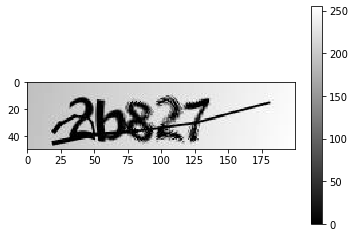

In [2]:
#Example of how imageio reads the data in visual form. the Captcha is in a clear dark purple. 
image = imageio.imread('../Project/train/2b827.png', as_gray=True)
print(image.shape)

plt.figure()
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

After we know how the image comes in we can set up a function to import and store all the images for testing or training sets. According to the Kaggle information all images are in 50 by 200 PNGS. Also found online are the symbols avaible to Captcha, which we can utilized for ensure the y match up with the limited options for Captcha. Having a limit of matches makes the match processing easier. Note: we utilized `as_gray=True` to indicate the images are in grey scale this reduces our shape from a (5,200,4) to (5,200) which aligns with the size of images perfectly. 

In [3]:
#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

#preprocessing the data into Numpy array's
def process_image(type):
    n_samples = len(os.listdir(type))
    X = np.zeros((n_samples, 50, 200, 1)) # the size of image is known to be 200 x 50 PNGs  and we have # of samples
    y = np.zeros((5, n_samples, num_symbols)) #5*970*36 shape

    for i,pic in enumerate(os.listdir(type)):
        # Read image as grayscale
        img = cv2.imread(os.path.join(type,pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        
        #All Captcha Images are assumed to be length of 5 characters
        if len(pic_target) < 6:
            
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            
            # Define targets based on file name and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
             
            #Write the pixels (encoded image) to X and the OneHotEncoded Label to y
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

Below we utlize the relative paths of train and test folders to set up the X,y datasets. Stored in process_data() is our function for utilizing cv2.imread lib  (same to imageio, but had less conflicts) for storing the data in vectors. 

In [4]:
#Create Train and Test sets
train = os.getcwd()+'/train'
test = os.getcwd()+'/test'

X_train, y_train = process_image(train)
X_test, y_test = process_image(test)

print("Shapes of X: train", X_train.shape, "test", X_test.shape)
print("Shapes of y: train", y_train.shape, "test", y_test.shape)

Shapes of X: train (970, 50, 200, 1) test (100, 50, 200, 1)
Shapes of y: train (5, 970, 36) test (5, 100, 36)


## Model Creation

Now that the data stored in the X,y for train and test we can create a CNN model. We are utilizing a CNN model because they were designed for image mapping. https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/. In creating the model we need to breadown the image from a whole view to try to get section of each letter/number for the model to match. Since we know there are only 5 characters in the captcha images we can use this for setting up 5 branches for the CNN. The activation function of relu was selected  in betwenn layers as this is a pretty standard starting point and is more computationally effiecent. Since the ultimate goal would be to accurately predict to break the captcha the evaluation metric being used is overall accuracy. 

In [5]:
def create_model():
    image = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(image)
    pool1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(pool2)
    bn = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(pool3)
    outputs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outputs.append(res)
    
    # Compile model and return it
    model = Model(image, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [6]:
#Setup the Model, History Logs 
model = create_model()


In [7]:
#Model fitting
hist = model.fit(X_train, [y_train[0],y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=32,
                 epochs=30, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 776 samples, validate on 194 samples
Epoch 1/30
776/776 [==============================] - 5s 6ms/step - loss: 17.0481 - dense_2_loss: 3.2655 - dense_4_loss: 3.4739 - dense_6_loss: 3.3825 - dense_8_loss: 3.4984 - dense_10_loss: 3.4187 - dense_2_accuracy: 0.0760 - dense_4_accuracy: 0.0657 - dense_6_accuracy: 0.0567 - dense_8_accuracy: 0.0451 - dense_10_accuracy: 0.0490 - val_loss: 17.7779 - val_dense_2_loss: 4.2920 - val_dense_4_loss: 3.3968 - val_dense_6_loss: 3.2872 - val_dense_8_loss: 3.4003 - val_dense_10_loss: 3.3454 - val_dense_2_accuracy: 0.0000e+00 - val_dense_4_accuracy: 0.0000e+00 - val_dense_6_accuracy: 0.1443 - val_dense_8_accuracy: 0.0361 - val_dense_10_accuracy: 0.1237
Epoch 2/30
776/776 [==============================] - 2s 2ms/step - loss: 15.9270 - dense_2_loss: 2.9720 - dense_4_loss: 3.2585 - dense_6_loss: 3.1782 - dense_8_loss: 3.2864 - dense_10_loss: 3.2335 - dense

In [8]:
#Model Evaluation
score_test = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],  verbose=1)
                            
print("Accuracy of Testing: ",score_test)

100/100 [==============================] - 0s 783us/step
Accuracy of Testing:  [nan, nan, 0.6501163244247437, 0.6200307607650757, 0.5717743039131165, 0.6035063862800598, 0.7900000214576721, 0.8700000047683716, 0.8299999833106995, 0.8700000047683716, 0.8500000238418579]


### Intrepretation of results

From the results of the test we can see that the model trained pretty well the 5 numbers give us the accuracy per letter. This averages for an overall ~83%. This is fairly accurate. Results may have been better with a lower validation size to allow for larger training set. 

#### Model 2

Though the model above is pretty good. It will still be wise to try out another model to see if we can make it even better. 1 option is to tune the parameters of the CNN also know as hyperparameterization. This can be done manually or through algothrims. Since we are dealing with less demsionality and more important pixel, I have taken a more manual approach. We noted above that there was also a line going through the image efforts to remove the line could also result in better results. 

In [9]:
#Rework the preprocessing to for getting rid of the line through the characters
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src): 
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.15 * src.shape[1])  # shape[1] = cols
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)

def process_v2(type):
    
    X=[]
    y=[]
    
    for image in list(os.listdir(type)):
        im=cv2.imread(os.path.join(type,image),0)
        threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
        erosion =cv2.dilate(threshold,kernel,iterations=2)
        s=str(image)
        for i in range(5):
            X.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
            y.append(s[-9+i])

    X = np.reshape(np.array(X),(-1,54,30,1))
    y = np.array(y)
        
    targ = []
    l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
    for j in y:
        i=l.index(j)
        a=[]
        for r in range(19):
            if(r==i):
                a.append(1)
            else:
                a.append(0)
        a=np.array(a)
        targ.append(a)
    targ=np.array(targ) 
    y=np.array(targ) 
        
    return X,y


In [10]:
X_train_v2, y_train_v2 = process_v2(train)
X_test_v2, y_test_v2 = process_v2(test)

In [11]:
def create_model_v2():
    model2 = Sequential()
    model2.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (54,30,1)))
    model2.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model2.add(MaxPool2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model2.add(MaxPool2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))


    model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Flatten())
    model2.add(Dense(256, activation = "relu"))
    model2.add(Dropout(0.5))
    model2.add(Dense(19, activation = "softmax"))
    
    

    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model2



In [12]:
#Setup learning rate for dropping out 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                              min_lr=0.00001)

#Inspired from another Kaggle Notebook for augmenting the image for randomization in should increase accuracy, 
# as we create randomization in the data during modeling to deal with shifts in the characters
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [13]:
#Due to using the fit_generator we will not be able to use the setting validation_split =.2 as we used earlier. 
#spliting the data
X_train_v2, X_val, y_train_v2, y_val = train_test_split(X_train_v2, y_train_v2, test_size = 0.1, random_state= 2)
X_train_v2=X_train_v2/255.0
X_val=X_val/255.0


#Fitting the model and augmenting the data
datagen.fit(X_train_v2)
model2 = create_model_v2()
history = model2.fit_generator(datagen.flow(X_train_v2,y_train_v2, batch_size=86),
                              epochs =  30, 
                              verbose = 1,
                              validation_data = (X_val,y_val),
                              steps_per_epoch=X_train_v2.shape[0] // 86,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
50/50 [==============================] - 5s 106ms/step - loss: 2.6901 - accuracy: 0.1676 - val_loss: 1.4184 - val_accuracy: 0.5464
Epoch 2/30
50/50 [==============================] - 5s 92ms/step - loss: 1.8472 - accuracy: 0.4291 - val_loss: 0.9868 - val_accuracy: 0.7814
Epoch 3/30
50/50 [==============================] - 5s 94ms/step - loss: 1.3281 - accuracy: 0.6050 - val_loss: 0.6371 - val_accuracy: 0.8289
Epoch 4/30
50/50 [==============================] - 5s 94ms/step - loss: 1.0437 - accuracy: 0.6915 - val_loss: 0.4241 - val_accuracy: 0.8639
Epoch 5/30
50/50 [==============================] - 5s 97ms/step - loss: 0.8638 - accuracy: 0.7357 - val_loss: 0.3046 - val_accuracy: 0.9052
Epoch 6/30
50/50 [==============================] - 5s 93ms/step - loss: 0.7027 - accuracy: 0.7950 - val_loss: 0.2789 - val_accuracy: 0.9155
Epoch 7/30
50/50 [==============================] - 4s 90ms/step - loss: 0.5986 - accuracy: 0.8177 - val_loss: 0.2206 - val_accuracy: 0.9278
Epoch 8/30
5

In [14]:
#Model Evaluation
score_test2 = model2.evaluate(X_test_v2,y_test_v2,  verbose=1)
                            
print("Accuracy of Testing: ",score_test2)

500/500 [==============================] - 0s 382us/step
Accuracy of Testing:  [21.08281930541992, 0.9660000205039978]


## Final Interpretation of Results

As seen above we can see that the second model overall had much better results with the test about 96.6% Accuracy. I will not there were some notable changes in this testing we used a 10% validation set, 0 and 1 were not included in the accecptable characters (ie only the characters that showed up in the 970 examples were utilized.) In addition to the overall model changing considerably there were double the amount of convultion and data was also fited for tilts in each of the charcters of the data set. With the restriction of characters to those found in the train set one may say this would make the general use case not as strong. Further examples and testing could be done to optimize for these or editing of the first model via more edge case, utlizing the same agumentation technique, or also using an optimizer on the first model could result in a better first model and more generalizeable model. 

#### Analyze Wrong Predictions

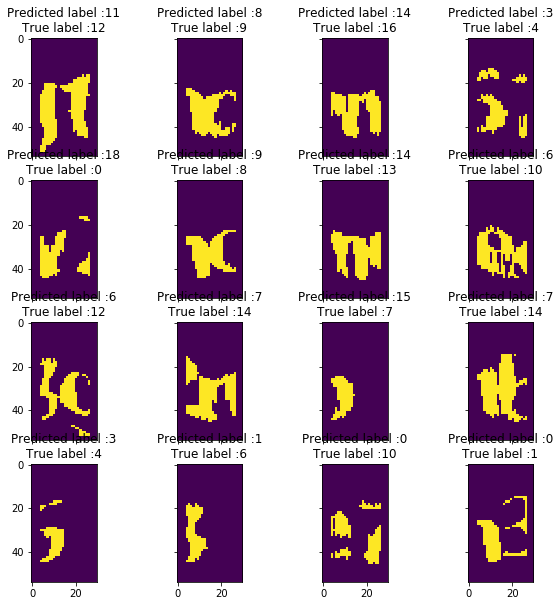

In [25]:
Y_predict = model2.predict(X_test_v2)

# Convert predictions classes and validation to one hot vectors 
predict_cl = np.argmax(Y_predict,axis = 1) 
Y_true = np.argmax(y_test_v2,axis = 1) 
errors = (predict_cl - Y_true != 0)

#Selection of only Errors from sets of data
Y_pred_classes_err = predict_cl[errors]
Y_pred_err = Y_predict[errors]
Y_true_err = Y_true[errors]
X_test_err = X_test_v2[errors]

# Probabilities of the wrong predicted numbers
Y_pred_err_prob = np.max(Y_pred_err,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_err = np.diagonal(np.take(Y_pred_err, Y_true_err, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_err = Y_pred_err_prob - true_prob_err

# Sorted list of the delta prob errors
sorted_err = np.argsort(delta_pred_true_err)

#  Calculate and Display Errors for Individual Characters
# Can be adjusted for top # of errors but the below shows the 20 Wrong
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 4
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(10,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((54,30)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            

#Calls above function to return Errors (Shape is 17 for cleaniness we pulled 4x4 = 16 errors of 17)
display_errors(sorted_err, X_test_err, Y_pred_classes_err, Y_true_err)

#l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
#l=[0    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18]

From the errors above we can see that marjority are off center from where the transformation split the image. Due to being off center key points seem to be missing from the image. Take 15th image for instance, the predicted label is a 2 however it really is a 'e', looking to the left side of the image that seems reasonable, however what appears to be a 2 or 7 is actually what is being picked up for the prediction as the image is clearer. We also see some streaking from the removal of the lines using the Gaussian Blur in the data processing. To enhance further we could consider adding stretching/translations to some of the pixel much like we did with the tilting variance we implemented while modeling. 

## Predicting Results

A model is useless unless you can put it into production. So for this we will need to create a function that we can call and predict  the results from. This can also act as another form of validation. Becuase the first model was faster in creation, the below function was made based on that model. However, this could be easily adapted for the other model and more than one input solver.

In [26]:
def prediction(filelocation):
    to_predict = cv2.imread(filelocation, cv2.IMREAD_GRAYSCALE)

    if to_predict is not None:
        to_predict = to_predict/ 255.0

    else: 
        print("File not found")
        
    res = np.array(model.predict(to_predict[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    
    #For each letter prediction we tage the max possibility much like Random Forest
    l_ind = []
    for a in ans: 
        l_ind.append(np.argmax(a))

    #Output a full captcha instead of a list of the letters predicted.   
    capt_ch = ''
    for l in l_ind:
        capt_ch += symbols[l]
        
    return capt_ch
        

In [27]:
print(prediction('../Project/train/22d5n.png'))
print(prediction('../Project/train/25w53.png'))
print(prediction('../Project/train/268g2.png'))
print(prediction('../Project/train/2ycn8.png'))

22d5n
25w53
268g2
2ycn8
